In [1]:
import torch
import torch.nn as nn

import math

In [2]:
torch.cuda.is_available()

False

In [3]:
print("Hello")

Hello


In [4]:
class Encoder(nn.Module):
    
    def __init__(self, n_in, n_hidden1, n_hidden2, n_hidden3, n_out):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_in, n_hidden1),
            nn.BatchNorm1d(n_hidden1),
            nn.Sigmoid()
        )

        self.layer2 = nn.Sequential(
            nn.Linear(n_hidden1, n_hidden2),
            nn.BatchNorm1d(n_hidden2),
            nn.Sigmoid()
        )

        self.layer3 = nn.Sequential(
            nn.Linear(n_hidden2, n_hidden3),
            nn.BatchNorm1d(n_hidden3),
            nn.Sigmoid()
        )

        self.layer4 = nn.Sequential(
            nn.Linear(n_hidden3, n_out),
            nn.BatchNorm1d(n_out),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return self.layer4(out)

In [5]:
class Decoder(nn.Module):
    
    def __init__(self, n_in, n_hidden1, n_hidden2, n_hidden3, n_out):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(n_in, n_hidden1),
            nn.BatchNorm1d(n_hidden1),
            nn.Sigmoid()
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(n_hidden1, n_hidden2),
            nn.BatchNorm1d(n_hidden2),
            nn.Sigmoid()
        )

        self.layer3 = nn.Sequential(
            nn.Linear(n_hidden2, n_hidden3),
            nn.BatchNorm1d(n_hidden3),
            nn.Sigmoid()
        )

        n_size = math.floor(math.sqrt(n_out))
        self.layer4 = nn.Sequential(
            nn.Linear(n_hidden3, n_out),
            nn.BatchNorm1d(n_out),
            nn.Sigmoid(),
            nn.Unflatten(1, torch.Size([1, n_size, n_size]))
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return self.layer4(out)

In [6]:
decoder = Decoder(2, 250, 500, 1000, 784)
decoder.eval()

ex = torch.tensor([3, 5.2]).view(1, 2)

decoder(ex).shape

torch.Size([1, 1, 28, 28])

In [7]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch.optim as optim

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is: ", device)

encoder = Encoder(784, 1000, 500, 250, 2).to(device)
decoder = Decoder(2, 250, 500, 1000, 784).to(device)

loss_fn: nn.MSELoss = nn.MSELoss()

optimizer = optim.Adam(
    list(decoder.parameters()) + list(encoder.parameters()), 
    lr=0.001, betas=(0.9, 0.999), eps=1e-8)

trainset = datasets.MNIST('./ds', True, ToTensor(), download=True)
train_loader = DataLoader(trainset, 32, True)

encoder.train()
decoder.train()

epochs = 20

for epoch in range(1, epochs + 1):

    running_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", ncols=100)

    for imgs, _ in loop:

        imgs = imgs.to(device)

        encoded = encoder(imgs)
        decoded = decoder(encoded)

        loss = loss_fn(decoded, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch}, Avg Loss: {avg_loss:.4f}")

Device is:  cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.0MB/s]
Epoch 1/20: 100%|██████████████████████████████████| 1875/1875 [00:19<00:00, 95.10it/s, loss=0.0784]


Epoch 1, Avg Loss: 0.1311


Epoch 2/20: 100%|█████████████████████████████████| 1875/1875 [00:18<00:00, 101.04it/s, loss=0.0521]


Epoch 2, Avg Loss: 0.0630


Epoch 3/20: 100%|██████████████████████████████████| 1875/1875 [00:18<00:00, 98.97it/s, loss=0.0493]


Epoch 3, Avg Loss: 0.0524


Epoch 4/20: 100%|█████████████████████████████████| 1875/1875 [00:18<00:00, 101.79it/s, loss=0.0516]


Epoch 4, Avg Loss: 0.0490


Epoch 5/20: 100%|██████████████████████████████████| 1875/1875 [00:18<00:00, 99.06it/s, loss=0.0438]


Epoch 5, Avg Loss: 0.0475


Epoch 6/20: 100%|████████████████████████████████████| 1875/1875 [00:19<00:00, 98.60it/s, loss=0.05]


Epoch 6, Avg Loss: 0.0465


Epoch 7/20: 100%|█████████████████████████████████| 1875/1875 [00:18<00:00, 100.62it/s, loss=0.0369]


Epoch 7, Avg Loss: 0.0458


Epoch 8/20: 100%|██████████████████████████████████| 1875/1875 [00:19<00:00, 98.28it/s, loss=0.0443]


Epoch 8, Avg Loss: 0.0453


Epoch 9/20: 100%|█████████████████████████████████| 1875/1875 [00:18<00:00, 101.60it/s, loss=0.0444]


Epoch 9, Avg Loss: 0.0448


Epoch 10/20: 100%|█████████████████████████████████| 1875/1875 [00:19<00:00, 98.28it/s, loss=0.0419]


Epoch 10, Avg Loss: 0.0442


Epoch 11/20: 100%|████████████████████████████████| 1875/1875 [00:18<00:00, 101.53it/s, loss=0.0425]


Epoch 11, Avg Loss: 0.0438


Epoch 12/20: 100%|█████████████████████████████████| 1875/1875 [00:19<00:00, 98.51it/s, loss=0.0411]


Epoch 12, Avg Loss: 0.0434


Epoch 13/20: 100%|█████████████████████████████████| 1875/1875 [00:18<00:00, 99.48it/s, loss=0.0459]


Epoch 13, Avg Loss: 0.0432


Epoch 14/20: 100%|████████████████████████████████| 1875/1875 [00:18<00:00, 101.37it/s, loss=0.0401]


Epoch 14, Avg Loss: 0.0427


Epoch 15/20: 100%|█████████████████████████████████| 1875/1875 [00:19<00:00, 98.64it/s, loss=0.0414]


Epoch 15, Avg Loss: 0.0423


Epoch 16/20: 100%|████████████████████████████████| 1875/1875 [00:18<00:00, 101.88it/s, loss=0.0487]


Epoch 16, Avg Loss: 0.0421


Epoch 17/20: 100%|██████████████████████████████████| 1875/1875 [00:18<00:00, 99.68it/s, loss=0.045]


Epoch 17, Avg Loss: 0.0419


Epoch 18/20: 100%|████████████████████████████████| 1875/1875 [00:18<00:00, 102.15it/s, loss=0.0389]


Epoch 18, Avg Loss: 0.0417


Epoch 19/20: 100%|███████████████████████████████████| 1875/1875 [00:18<00:00, 99.46it/s, loss=0.04]


Epoch 19, Avg Loss: 0.0414


Epoch 20/20: 100%|████████████████████████████████| 1875/1875 [00:18<00:00, 101.59it/s, loss=0.0381]

Epoch 20, Avg Loss: 0.0412


0


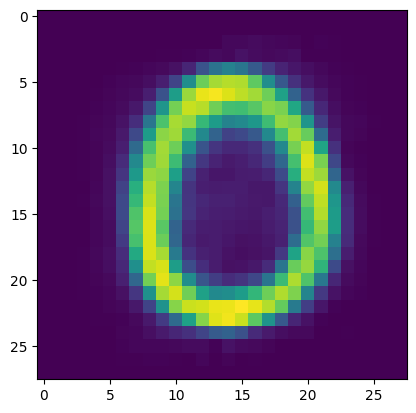

In [20]:
import matplotlib.pyplot as plt

number, label = trainset[88]
number.shape, label

print(label)

number = number.to(device)

encoder.eval()
decoder.eval()

code = encoder(number)
out = decoder(code)[0]
out.shape
# plt.imshow(number.cpu().permute(1, 2, 0))
plt.imshow(out.detach().cpu().permute(1, 2, 0))
plt.show()

In [25]:
pairs = [[] for _ in range(10)]

for i, (img, label) in enumerate(trainset):
    img = img.to(device)
    code = encoder(img)
    pair = (code[0][0].item(), code[0][1].item())
    pairs[label].append(pair)

len(pairs)


10

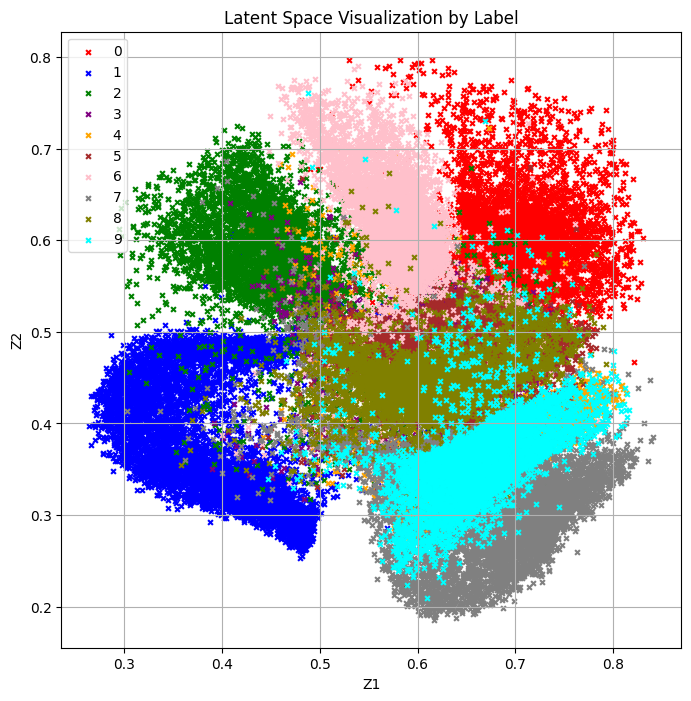

In [ ]:
import matplotlib.pyplot as plt

colors = [
    "red", "blue", "green", "purple", "orange",
    "brown", "pink", "gray", "olive", "cyan"
]

plt.figure(figsize=(8, 8))

for label in range(10):
    group = pairs[label]

    xs = [p[0] for p in group]
    ys = [p[1] for p in group]

    plt.scatter(xs, ys, s=12, marker='x', color=colors[label], label=str(label))

plt.title("Latent Space Visualization by Label")
plt.xlabel("Z1")
plt.ylabel("Z2")
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
def corrupt_image(img: torch.tensor, factor=0.5):

    corrupting_matrix = 0.5 * torch.rand_like(img, )
    return img * corrupting_matrix

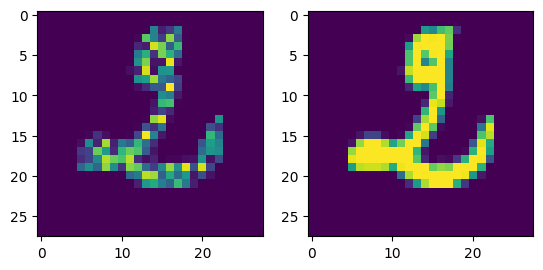

In [82]:
img, _ = trainset[190]

c_img = corrupt_image(img)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(c_img.permute(1, 2, 0))
ax[1].imshow(img.permute(1, 2, 0));

In [83]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch.optim as optim

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is: ", device)

corrupt_encoder = Encoder(784, 1000, 500, 250, 2).to(device)
corrupt_decoder = Decoder(2, 250, 500, 1000, 784).to(device)

loss_fn: nn.MSELoss = nn.MSELoss()

optimizer = optim.Adam(
    list(corrupt_decoder.parameters()) + list(corrupt_encoder.parameters()), 
    lr=0.001, betas=(0.9, 0.999), eps=1e-8)

trainset = datasets.MNIST('./ds', True, ToTensor(), download=True)
train_loader = DataLoader(trainset, 32, True)

corrupt_encoder.train()
corrupt_decoder.train()

epochs = 20

for epoch in range(1, epochs + 1):

    running_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", ncols=100)

    for imgs, _ in loop:

        imgs = imgs.to(device)
        c_imgs = corrupt_image(imgs)

        encoded = corrupt_encoder(c_imgs)
        decoded = corrupt_decoder(encoded)

        loss = loss_fn(decoded, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch}, Avg Loss: {avg_loss:.4f}")

Device is:  cuda


Epoch 1/25: 100%|██████████████████████████████████| 1875/1875 [00:18<00:00, 99.12it/s, loss=0.0765]


Epoch 1, Avg Loss: 0.1308


Epoch 2/25: 100%|██████████████████████████████████| 1875/1875 [00:18<00:00, 99.92it/s, loss=0.0554]


Epoch 2, Avg Loss: 0.0627


Epoch 3/25: 100%|████████████████████████████████████| 1875/1875 [00:18<00:00, 99.00it/s, loss=0.05]


Epoch 3, Avg Loss: 0.0529


Epoch 4/25: 100%|█████████████████████████████████| 1875/1875 [00:18<00:00, 101.33it/s, loss=0.0489]


Epoch 4, Avg Loss: 0.0496


Epoch 5/25: 100%|██████████████████████████████████| 1875/1875 [00:18<00:00, 98.82it/s, loss=0.0454]


Epoch 5, Avg Loss: 0.0480


Epoch 6/25: 100%|██████████████████████████████████| 1875/1875 [00:18<00:00, 101.34it/s, loss=0.047]


Epoch 6, Avg Loss: 0.0470


Epoch 7/25: 100%|██████████████████████████████████| 1875/1875 [00:18<00:00, 98.80it/s, loss=0.0426]


Epoch 7, Avg Loss: 0.0462


Epoch 8/25: 100%|██████████████████████████████████| 1875/1875 [00:18<00:00, 98.70it/s, loss=0.0413]


Epoch 8, Avg Loss: 0.0456


Epoch 9/25: 100%|██████████████████████████████████| 1875/1875 [00:18<00:00, 99.31it/s, loss=0.0457]


Epoch 9, Avg Loss: 0.0451


Epoch 10/25: 100%|██████████████████████████████████| 1875/1875 [00:19<00:00, 97.32it/s, loss=0.041]


Epoch 10, Avg Loss: 0.0446


Epoch 11/25: 100%|████████████████████████████████| 1875/1875 [00:18<00:00, 101.13it/s, loss=0.0427]


Epoch 11, Avg Loss: 0.0442


Epoch 12/25: 100%|█████████████████████████████████| 1875/1875 [00:18<00:00, 98.96it/s, loss=0.0413]


Epoch 12, Avg Loss: 0.0438


Epoch 13/25: 100%|█████████████████████████████████| 1875/1875 [00:18<00:00, 101.65it/s, loss=0.045]


Epoch 13, Avg Loss: 0.0433


Epoch 14/25: 100%|██████████████████████████████████| 1875/1875 [00:19<00:00, 98.66it/s, loss=0.038]


Epoch 14, Avg Loss: 0.0430


Epoch 15/25: 100%|████████████████████████████████| 1875/1875 [00:18<00:00, 100.96it/s, loss=0.0383]


Epoch 15, Avg Loss: 0.0427


Epoch 16/25: 100%|█████████████████████████████████| 1875/1875 [00:18<00:00, 99.36it/s, loss=0.0363]


Epoch 16, Avg Loss: 0.0423


Epoch 17/25: 100%|█████████████████████████████████| 1875/1875 [00:19<00:00, 98.32it/s, loss=0.0391]


Epoch 17, Avg Loss: 0.0420


Epoch 18/25: 100%|█████████████████████████████████| 1875/1875 [00:18<00:00, 101.18it/s, loss=0.039]


Epoch 18, Avg Loss: 0.0418


Epoch 19/25: 100%|█████████████████████████████████| 1875/1875 [00:19<00:00, 97.45it/s, loss=0.0418]


Epoch 19, Avg Loss: 0.0415


Epoch 20/25: 100%|████████████████████████████████| 1875/1875 [00:18<00:00, 100.00it/s, loss=0.0393]


Epoch 20, Avg Loss: 0.0414


Epoch 21/25: 100%|█████████████████████████████████| 1875/1875 [00:19<00:00, 98.62it/s, loss=0.0389]


Epoch 21, Avg Loss: 0.0411


Epoch 22/25: 100%|██████████████████████████████████| 1875/1875 [00:18<00:00, 99.66it/s, loss=0.041]


Epoch 22, Avg Loss: 0.0409


Epoch 23/25: 100%|█████████████████████████████████| 1875/1875 [00:18<00:00, 99.87it/s, loss=0.0438]


Epoch 23, Avg Loss: 0.0408


Epoch 24/25: 100%|█████████████████████████████████| 1875/1875 [00:18<00:00, 98.86it/s, loss=0.0346]


Epoch 24, Avg Loss: 0.0407


Epoch 25/25: 100%|████████████████████████████████| 1875/1875 [00:18<00:00, 101.16it/s, loss=0.0366]

Epoch 25, Avg Loss: 0.0404


In [ ]:
def binary_search(arr, target):
    """
    Binary search algorithm to find target in a sorted array.
    
    Args:
        arr: A sorted list of comparable elements
        target: The element to search for
    
    Returns:
        The index of target if found, -1 otherwise
    """
    left = 0
    right = len(arr) - 1
    
    while left <= right:
        mid = (left + right) // 2
        
        if arr[mid] == target:
            return mid
        elif arr[mid] < target:
            left = mid + 1
        else:
            right = mid - 1
    
    return -1


# Example usage
sorted_array = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
target = 7

result = binary_search(sorted_array, target)
print(f"Target {target} found at index: {result}")

# Test with element not in array
result2 = binary_search(sorted_array, 10)
print(f"Target 10 found at index: {result2}")  # Should return -1
